In [1]:
# Mall Customers Clustering using K-Means and DBSCAN

# Import libraries
import kagglehub
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
# Download dataset
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
print("Path to dataset files:", path)

# Check files
print("Files:", os.listdir(path))

# Load dataset
csv_path = os.path.join(path, "Mall_Customers.csv")
df = pd.read_csv(csv_path)

# Dataset info
print("Dataset shape:", df.shape)
print(df.head())
print("Dataset columns:", df.columns)
print("Number of duplicates:", df.duplicated().sum())
print("Number of NAN:\n", df.isna().sum())

Path to dataset files: C:\Users\Tasneem\.cache\kagglehub\datasets\vjchoudhary7\customer-segmentation-tutorial-in-python\versions\1
Files: ['Mall_Customers.csv']
Dataset shape: (200, 5)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Dataset columns: Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
Number of duplicates: 0
Number of NAN:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


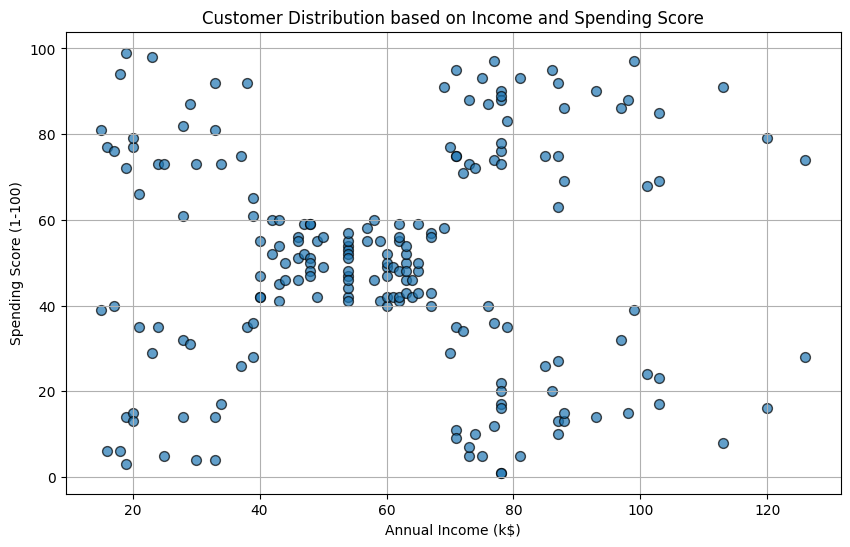

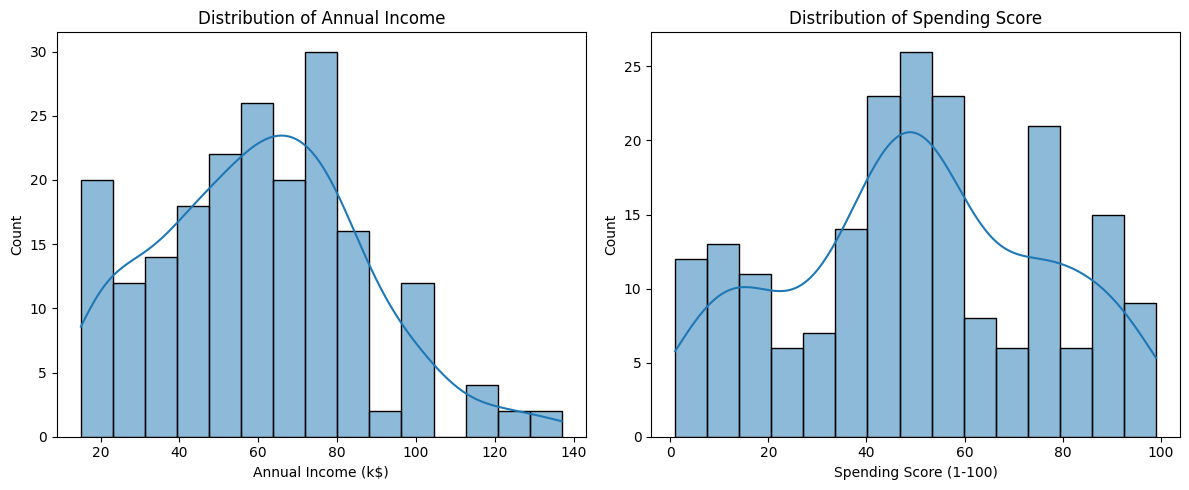

In [3]:
# Feature Selection
X= df[['Annual Income (k$)','Spending Score (1-100)']]

# Remove the outliers using IQR method
Q1= X.quantile(0.25)
Q3=X.quantile(0.75)
IQR= Q3-Q1

X_no_outliers = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]

# Scaling
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X_no_outliers)

# Visual Exploration
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(X_no_outliers['Annual Income (k$)'], X_no_outliers['Spending Score (1-100)'], s=50, alpha=0.7, edgecolors='k')
plt.title('Customer Distribution based on Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

# Feature distribution
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df['Annual Income (k$)'], bins=15, kde=True)
plt.title('Distribution of Annual Income')

plt.subplot(1, 2, 2)
sns.histplot(df['Spending Score (1-100)'], bins=15, kde=True)
plt.title('Distribution of Spending Score')

plt.tight_layout()
plt.show()


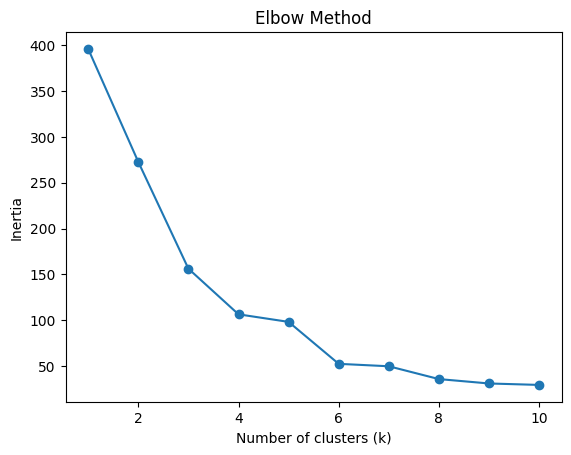

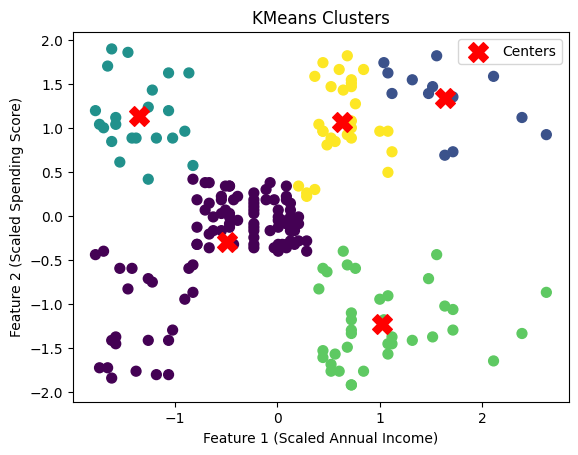

Silhouette Score (K-Means): 0.4366

Average Spending per K-Means Cluster:
 Cluster
0    42.814433
1    84.615385
2    79.363636
3    18.648649
4    77.586207
Name: Spending Score (1-100), dtype: float64


In [4]:
# Determine The optimal number of clusters using elbow method

inertia=[]

for k in range(1,11):
    kmeans= KMeans(n_clusters= k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.Figure(figsize=(10,6))
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


# Build and fit the K-Means model
model= KMeans(n_clusters=5, random_state=42)
model.fit(X_scaled)

# Cluster labels and centers
labels= model.labels_
centers= model.cluster_centers_

# Visualize K-Means clusters
plt.Figure(figsize=(10,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, cmap='viridis', s=50)
plt.scatter(centers[:,0],centers[:,1], c='red', marker='X', s=200, label='Centers')
plt.xlabel('Feature 1 (Scaled Annual Income)')
plt.ylabel('Feature 2 (Scaled Spending Score)')
plt.title('KMeans Clusters')
plt.legend()
plt.show()

# Silhouette Score for K-Means
score1 = silhouette_score(X_scaled, labels)
print(f'Silhouette Score (K-Means): {score1:.4f}')

# Average Spending per K-Means cluster
X_kmeans= X_no_outliers.copy()
X_kmeans['Cluster']= labels
avg_spending_kmeans= X_kmeans.groupby('Cluster')['Spending Score (1-100)'].mean()
print("\nAverage Spending per K-Means Cluster:\n", avg_spending_kmeans)


eps0.2 : n_clusters6
eps0.4 : n_clusters4
eps0.6 : n_clusters1
eps0.8 : n_clusters1
eps1.0 : n_clusters1

Best eps based on cluster count: 0.2 (6 clusters)


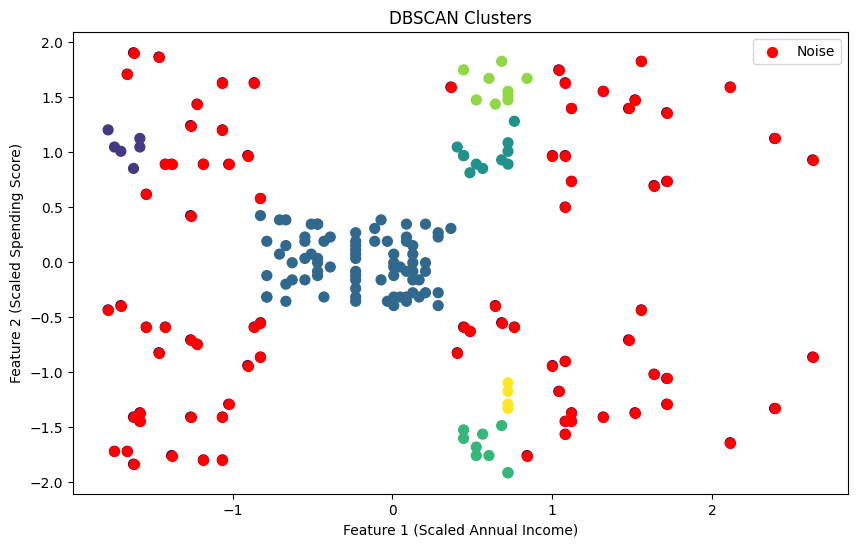

Silhouette Score (DBSCAN): 0.5806

Average Spending per DBSCAN Cluster:
 Cluster
0    77.000000
1    50.025641
2    75.181818
3     6.777778
4    91.111111
5    18.750000
Name: Spending Score (1-100), dtype: float64

DBSCAN performed better based on the Silhouette Score.


In [9]:
# Try DBSCAN clustering
# Tune the eps parameter
best_eps= None
max_clusters=0

for eps in [0.2,0.4,0.6,0.8,1.0]:
    model_temp= DBSCAN(eps=eps, min_samples=5)
    labels_temp= model_temp.fit_predict(X_scaled)
    n_clusters= len(set(labels_temp))-(1 if -1 in labels_temp else 0)
    print(f"eps{eps} : n_clusters{n_clusters}")

    # store the eps that gave the most valid clusters (ignoring 1-cluster results)
    if n_clusters > max_clusters and n_clusters > 1:
        max_clusters= n_clusters
        best_eps= eps

print(f"\nBest eps based on cluster count: {best_eps} ({max_clusters} clusters)")
    

# Bulid anf fit the DBSCAN model
model2= DBSCAN(eps=best_eps, min_samples=5)
model2.fit(X_scaled)

# Cluster labels
labels2= model2.labels_

# Visualize DBSCAN clusters
plt.figure(figsize=(10,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels2, cmap='viridis', s=50)
plt.scatter(X_scaled[labels2==-1,0],X_scaled[labels2==-1,1], c='red', s=50, label='Noise')
plt.xlabel('Feature 1 (Scaled Annual Income)')
plt.ylabel('Feature 2 (Scaled Spending Score)')
plt.title('DBSCAN Clusters')
plt.legend()
plt.show()

# Silhouette Score for DBSCAN (if valid)
if len(set(labels2)) > 1 and -1 in labels2:
    mask= labels2 != -1
    score2= silhouette_score(X_scaled[mask], labels2[mask])
elif len(set(labels2)) > 1:
    score2= silhouette_score(X_scaled, labels2)
else:
    score2=-1 # invalid (only one cluster found)

print(f'Silhouette Score (DBSCAN): {score2:.4f}')

# Average Spending per DBSCAN cluster (excluding outliers)
X_dbscan= X_no_outliers.copy()
X_dbscan['Cluster']= labels2
avg_spending_dbscan= X_dbscan[X_dbscan['Cluster'] != -1].groupby('Cluster')['Spending Score (1-100)'].mean()
print("\nAverage Spending per DBSCAN Cluster:\n", avg_spending_dbscan)


# Compare models
if score1 > score2:
    print("\nK-Means performed better based on the Silhouette Score.")
elif score2 > score1:
    print("\nDBSCAN performed better based on the Silhouette Score.")
else:
    print("\nBoth performed similarly based on the Silhouette Score.")

